In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# 데이터 임포트
import os
import pandas as pd

os.chdir("/content/drive/MyDrive/open")

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')

In [ ]:
# 모듈 임포트
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

train 데이터셋에 정상 데이터가 월등히 많기 때문에, 랜덤으로 뽑아서 정상 데이터라고 가정

In [ ]:
# 데이터 라벨링 및 전처리
class_0_sample = train_df.sample(frac=0.8, replace=False)
class_0_sample

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
55465,138017,-0.688175,0.790247,1.865052,1.552573,-0.707023,0.852548,-0.407201,0.856223,0.246791,...,-0.265630,-0.502401,-0.028470,-0.008494,-0.303211,-0.459676,0.087259,0.081240,-0.148955,-0.026398
99274,248075,2.052962,0.101032,-2.061370,0.139861,0.708547,-0.992524,0.637264,-0.346230,-0.076496,...,0.165321,0.519705,0.009552,0.793465,0.402602,-0.223746,-0.065282,-0.070935,-0.099211,0.811758
40390,100377,-0.687770,-0.313360,0.017895,-0.803174,-0.354524,0.049855,0.266720,0.102801,-1.036629,...,0.266734,0.817296,-0.213891,-0.724961,-0.513179,-0.085296,-0.109877,-0.241216,1.591560,-0.202035
89688,224189,-0.231057,0.449427,-0.975381,-0.299616,-0.325232,1.071681,2.682511,-0.505684,-0.065531,...,-0.123350,0.086768,0.238178,0.142864,-0.904659,-0.172483,0.121292,-0.055009,5.493188,0.693077
109178,273075,-2.669792,3.188421,-0.232399,2.206211,0.551827,0.441592,0.488823,0.465867,-1.056355,...,0.024531,-0.556317,0.216456,0.656629,-0.592143,-0.621562,-1.356682,0.015637,-0.282960,0.948272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85500,213649,-0.882367,1.482644,-0.551589,-0.544237,-0.308714,-1.267765,0.262050,0.676889,-0.127473,...,-0.212423,-0.649736,0.184024,0.024476,-0.407427,0.148611,0.110147,0.019524,-0.175784,0.641984
104541,261532,-0.073304,-0.434902,1.376645,-3.328546,-0.438309,-0.792777,0.193538,-0.421106,-1.837773,...,-0.109453,0.335461,-0.201058,-0.108678,-0.290593,-0.440430,-0.004679,-0.062899,-0.194229,0.885431
19700,48987,1.241935,-0.014318,0.293430,0.301022,-0.248384,-0.221737,-0.122865,0.004584,0.483780,...,-0.246897,-0.568377,0.052488,-0.248136,0.293454,0.498026,-0.028723,0.002950,-0.251520,-0.479670
98124,245244,0.017787,1.243268,-1.924447,-0.602362,1.346264,-0.878289,1.007563,0.233095,-0.772426,...,0.212993,0.545728,-0.153764,0.295110,-0.398819,0.515921,-0.072576,0.053684,-0.274436,0.798529


In [ ]:
class_0_sample = class_0_sample.drop(['ID'], axis=1)

In [ ]:
# validation 데이터 정의
val_x = val_df.drop(columns=['ID','Class'])
val_y = val_df['Class']

In [ ]:
# 오차항 정의
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [ ]:
# The reparameterization trick
# 데이터 분포를 바꿔주는 함수 

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
# 차원 정의

original_dim = class_0_sample.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [ ]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 30)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 15)           465         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 10)           160         ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 10)           160         ['dense[0][0]']                  
                                                                                            

In [ ]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 10)]              0         
                                                                 
 dense_1 (Dense)             (None, 15)                165       
                                                                 
 dense_2 (Dense)             (None, 30)                480       
                                                                 
Total params: 645
Trainable params: 645
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [ ]:
# the KL loss function: 
# VAE의 비용 함수인 KL 발산

def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [ ]:
# 모델 학습
vae_model.compile(optimizer="rmsprop", loss=vae_loss)
vae_model.summary()

# Finally, we train the model:
results = vae_model.fit(class_0_sample, class_0_sample,
                        shuffle=True,
                        epochs=30,
                        batch_size=256)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 30)]              0         
                                                                 
 encoder (Functional)        (None, 10)                785       
                                                                 
 decoder (Functional)        (None, 30)                645       
                                                                 
Total params: 1,430
Trainable params: 1,430
Non-trainable params: 0
_________________________________________________________________
Train on 91074 samples
Epoch 1/30
91074/91074 [==============================] - 1s 15us/sample - loss: 75604025095053776.0000
Epoch 2/30
91074/91074 [==============================] - 1s 7us/sample - loss: 65140907985733216.0000
Epoch 3/30
91074/91074 [==============================] - 1s 10us/sample - loss: 5144044691

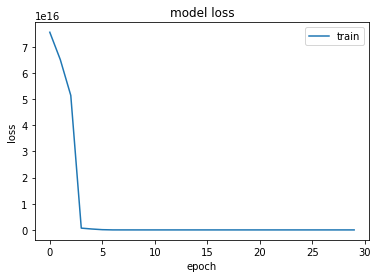

In [ ]:
# loss 그래프로 모델 학습 결과 확인

plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [ ]:
# prediction

val_x_pred = vae_model.predict(val_x)

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
mae_vector = get_error_term(val_x_pred, val_x, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.5383939170250015
median error 0.46984225216044795
99Q: 1.936358577213926
setting threshold on 1.936358577213926 


In [ ]:
# prediction한 것으로 이상치 찾아내기 
anomalies = (mae_vector > error_thresh)
np.count_nonzero(anomalies) / len(anomalies) #이상치 비율

0.010013351134846462

In [ ]:
# 정확도 행렬 확인 
from sklearn.metrics import classification_report

print(classification_report(val_y, anomalies))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     28432
           1       0.07      0.63      0.12        30

    accuracy                           0.99     28462
   macro avg       0.53      0.81      0.56     28462
weighted avg       1.00      0.99      0.99     28462



## VAE scaling (minmax)

In [ ]:
# 데이터 라벨링 및 전처리
class_0_sample = train_df.sample(frac=0.8, replace=False)
class_0_sample

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
109831,274720,-0.395676,0.777782,0.165311,-0.851634,1.117452,-1.398650,1.710514,-0.852957,0.258354,...,0.136380,0.842693,-0.305138,-0.021773,0.377381,-0.281479,-0.511858,-0.432950,0.154964,0.957272
205,537,1.131541,-0.174361,0.992621,0.600032,-1.021934,-0.644779,-0.428619,-0.032071,0.516318,...,0.022068,-0.031149,0.022845,0.414591,0.129935,0.387228,-0.016423,0.034255,0.424789,-0.990249
32744,81491,1.238043,0.770530,-0.331998,1.345465,0.139816,-1.229676,0.354259,-0.280805,-0.184996,...,-0.060570,-0.071096,-0.131000,0.269144,0.712100,-0.329489,0.039308,0.058838,-0.293440,-0.302377
53439,132938,-0.237135,-4.270770,0.337577,-0.351525,-2.731400,1.353471,-0.848786,0.281806,-0.642373,...,0.079946,-0.830923,-0.677493,-0.267888,-0.023203,-0.263681,-0.050772,0.153602,11.360302,-0.052985
53812,133885,0.894258,-0.327235,-0.166174,1.135400,-0.030057,0.119024,0.240464,0.094359,0.039812,...,0.099504,0.059479,-0.289118,-0.303268,0.692327,-0.256227,-0.012894,0.020037,1.809684,-0.048532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30180,75065,1.214132,0.271087,-0.292709,0.880706,0.287801,-0.252426,0.246390,0.049230,-0.258470,...,0.040439,0.092159,-0.147433,-0.334491,0.735434,-0.257980,-0.006837,-0.009787,-0.294977,-0.338456
45385,112774,-1.368851,1.514854,0.679011,1.154238,-0.388080,0.551933,-0.139067,1.120345,-0.786197,...,0.061335,0.160857,-0.161947,-0.299121,0.215686,-0.176876,0.013457,0.014831,0.150213,-0.139710
18373,45744,-0.340397,0.168612,1.933920,-1.040889,-0.666100,-0.125930,-0.160540,0.217909,-1.653811,...,0.072602,0.022220,0.007301,0.176385,-0.401081,-0.397603,0.113489,0.097935,-0.139733,-0.495917
77343,193050,-1.593818,1.234481,2.974995,4.344022,-0.261743,1.101896,-0.189561,0.169217,-0.638361,...,-0.046710,0.851342,-0.003825,0.064439,0.243371,0.566316,0.679676,0.135785,0.149794,0.531949


In [ ]:
class_0_sample = class_0_sample.drop(['ID'], axis=1)

In [ ]:
# validation 데이터 정의
val_x = val_df.drop(columns=['ID','Class'])
val_y = val_df['Class']

In [ ]:
# MinMax scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

sample_scaled = scaler.fit_transform(class_0_sample)
val_scaled = scaler.transform(val_x)

In [ ]:
# 오차항 정의
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [ ]:
# The reparameterization trick
# 데이터 분포를 바꿔주는 함수 

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
# 차원 정의

original_dim = sample_scaled.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [ ]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 30)]         0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 15)           465         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 10)           160         ['dense_3[0][0]']                
                                                                                                  
 z_log_var (Dense)              (None, 10)           160         ['dense_3[0][0]']                
                                                                                            

In [ ]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 10)]              0         
                                                                 
 dense_4 (Dense)             (None, 15)                165       
                                                                 
 dense_5 (Dense)             (None, 30)                480       
                                                                 
Total params: 645
Trainable params: 645
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [ ]:
# the KL loss function: 
# VAE의 비용 함수인 KL 발산

def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [ ]:
# 모델 학습
vae_model.compile(optimizer="rmsprop", loss=vae_loss)
vae_model.summary()

# Finally, we train the model:
results = vae_model.fit(sample_scaled, sample_scaled,
                        shuffle=True,
                        epochs=30,
                        batch_size=256)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 30)]              0         
                                                                 
 encoder (Functional)        (None, 10)                785       
                                                                 
 decoder (Functional)        (None, 30)                645       
                                                                 
Total params: 1,430
Trainable params: 1,430
Non-trainable params: 0
_________________________________________________________________
Train on 91074 samples
Epoch 1/30
91074/91074 [==============================] - 2s 20us/sample - loss: 86.9564
Epoch 2/30
91074/91074 [==============================] - 1s 9us/sample - loss: 27.7936
Epoch 3/30
91074/91074 [==============================] - 1s 10us/sample - loss: 24.1762
Epoch 4/30
91074/91074 [========

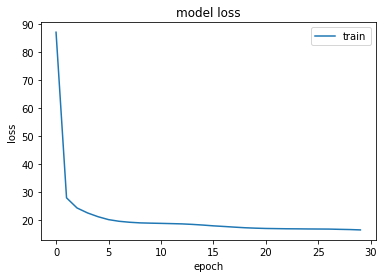

In [ ]:
# loss 그래프로 모델 학습 결과 확인

plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [ ]:
# prediction

val_x_pred = vae_model.predict(val_scaled)

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
mae_vector = get_error_term(val_x_pred, val_scaled, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.025625453683638097
median error 0.024085804165763454
99Q: 0.055438123893974206
setting threshold on 0.055438123893974206 


In [ ]:
# prediction한 것으로 이상치 찾아내기 
anomalies = (mae_vector > error_thresh)
np.count_nonzero(anomalies) / len(anomalies) #이상치 비율

0.010013351134846462

In [ ]:
# 정확도 행렬 확인 
from sklearn.metrics import classification_report, f1_score


val_score = f1_score(val_y, anomalies, average='macro')

print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, anomalies))

Validation F1 Score : [0.5706399257283392]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     28432
           1       0.08      0.77      0.15        30

    accuracy                           0.99     28462
   macro avg       0.54      0.88      0.57     28462
weighted avg       1.00      0.99      0.99     28462



## VAE feature 조정

모든 특성 다 사용했을 때의 스코어 = [0.5706399257283392]

In [ ]:
class_0_sample

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
109831,-0.395676,0.777782,0.165311,-0.851634,1.117452,-1.398650,1.710514,-0.852957,0.258354,-0.766738,...,0.136380,0.842693,-0.305138,-0.021773,0.377381,-0.281479,-0.511858,-0.432950,0.154964,0.957272
205,1.131541,-0.174361,0.992621,0.600032,-1.021934,-0.644779,-0.428619,-0.032071,0.516318,-0.118985,...,0.022068,-0.031149,0.022845,0.414591,0.129935,0.387228,-0.016423,0.034255,0.424789,-0.990249
32744,1.238043,0.770530,-0.331998,1.345465,0.139816,-1.229676,0.354259,-0.280805,-0.184996,-0.699813,...,-0.060570,-0.071096,-0.131000,0.269144,0.712100,-0.329489,0.039308,0.058838,-0.293440,-0.302377
53439,-0.237135,-4.270770,0.337577,-0.351525,-2.731400,1.353471,-0.848786,0.281806,-0.642373,0.783301,...,0.079946,-0.830923,-0.677493,-0.267888,-0.023203,-0.263681,-0.050772,0.153602,11.360302,-0.052985
53812,0.894258,-0.327235,-0.166174,1.135400,-0.030057,0.119024,0.240464,0.094359,0.039812,0.030640,...,0.099504,0.059479,-0.289118,-0.303268,0.692327,-0.256227,-0.012894,0.020037,1.809684,-0.048532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30180,1.214132,0.271087,-0.292709,0.880706,0.287801,-0.252426,0.246390,0.049230,-0.258470,0.221705,...,0.040439,0.092159,-0.147433,-0.334491,0.735434,-0.257980,-0.006837,-0.009787,-0.294977,-0.338456
45385,-1.368851,1.514854,0.679011,1.154238,-0.388080,0.551933,-0.139067,1.120345,-0.786197,-0.327337,...,0.061335,0.160857,-0.161947,-0.299121,0.215686,-0.176876,0.013457,0.014831,0.150213,-0.139710
18373,-0.340397,0.168612,1.933920,-1.040889,-0.666100,-0.125930,-0.160540,0.217909,-1.653811,0.429305,...,0.072602,0.022220,0.007301,0.176385,-0.401081,-0.397603,0.113489,0.097935,-0.139733,-0.495917
77343,-1.593818,1.234481,2.974995,4.344022,-0.261743,1.101896,-0.189561,0.169217,-0.638361,2.511233,...,-0.046710,0.851342,-0.003825,0.064439,0.243371,0.566316,0.679676,0.135785,0.149794,0.531949


In [ ]:
# PCA 진행
from sklearn.decomposition import PCA

pca = PCA(n_components=25)

sample_pca = pca.fit_transform(class_0_sample)
sample_pca = pd.DataFrame(sample_pca)

val_x_pca = pca.transform(val_x)
val_x_pca = pd.DataFrame(val_x_pca)

In [ ]:
# MinMax scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

sample_pca_scaled = scaler.fit_transform(sample_pca)
val_pca_scaled = scaler.transform(val_x_pca)

In [ ]:
# 차원 정의

original_dim = sample_pca_scaled.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [ ]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')

# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')

# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [ ]:
# 모델 학습
vae_model.compile(optimizer="rmsprop", loss=vae_loss)
vae_model.summary()

# Finally, we train the model:
results = vae_model.fit(sample_pca_scaled, sample_pca_scaled,
                        shuffle=True,
                        epochs=30,
                        batch_size=256)

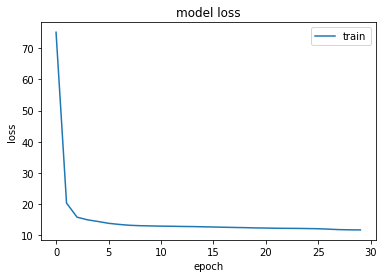

In [ ]:
# loss 그래프로 모델 학습 결과 확인

plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [ ]:
# 예측 및 문턱값 정의

val_pca_pred = vae_model.predict(val_pca_scaled)

mae_vector = get_error_term(val_pca_pred, val_pca_scaled, _rmse=False)

print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Avg error 0.02447385257123011
median error 0.023146402778433682
99Q: 0.05415718543572091
setting threshold on 0.05415718543572091 


In [ ]:
# 이상치 정의 및 비율 파악
anomalies = (mae_vector > error_thresh)
np.count_nonzero(anomalies) / len(anomalies)

0.010013351134846462

In [ ]:
# 평가
# from sklearn.metrics import classification_report, f1_score

val_score_pca = f1_score(val_y, anomalies, average='macro')

print(f'Validation F1 Score : [{val_score_pca}]')
print(classification_report(val_y, anomalies))

Validation F1 Score : [0.5706399257283392]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     28432
           1       0.08      0.77      0.15        30

    accuracy                           0.99     28462
   macro avg       0.54      0.88      0.57     28462
weighted avg       1.00      0.99      0.99     28462



In [ ]:
# 모든 feature 사용했을 때와 완전히 동일
print(f'Validation F1 Score : [{val_score}]')

Validation F1 Score : [0.5706399257283392]


In [ ]:
# feature selection
selected_feature = [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 21, 27, 30]
feature_num = [selected_feature[i] - 1 for i in range(len(selected_feature))]

train_df_2 = class_0_sample.iloc[:, feature_num]
val_df_2 = val_x.iloc[:, feature_num]

In [ ]:
# MinMax scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_2_scaled = scaler.fit_transform(train_df_2)
val_2_scaled = scaler.transform(val_df_2)

In [ ]:
# 차원 정의

original_dim = train_2_scaled.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [ ]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')

# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')

# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [ ]:
# 모델 학습
vae_model.compile(optimizer="rmsprop", loss=vae_loss)
vae_model.summary()

# Finally, we train the model:
results = vae_model.fit(train_2_scaled, train_2_scaled,
                        shuffle=True,
                        epochs=30,
                        batch_size=256)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 18)]              0         
                                                                 
 encoder (Functional)        (None, 6)                 291       
                                                                 
 decoder (Functional)        (None, 18)                243       
                                                                 
Total params: 534
Trainable params: 534
Non-trainable params: 0
_________________________________________________________________
Train on 91074 samples
Epoch 1/30
91074/91074 [==============================] - 1s 11us/sample - loss: 68.0453
Epoch 2/30
91074/91074 [==============================] - 1s 6us/sample - loss: 18.3175
Epoch 3/30
91074/91074 [==============================] - 1s 6us/sample - loss: 11.8974
Epoch 4/30
91074/91074 [=============

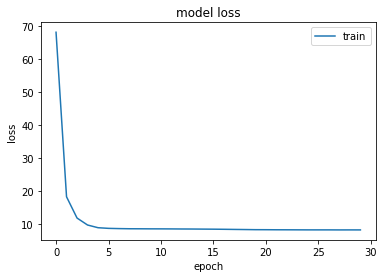

In [ ]:
# loss 그래프로 모델 학습 결과 확인

plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [ ]:
# 예측 및 문턱값 정의

val_2_pred = vae_model.predict(val_2_scaled)

mae_vector = get_error_term(val_2_pred, val_2_scaled, _rmse=False)

print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Avg error 0.024591961732877945
median error 0.022823635358577607
99Q: 0.060008623615320646
setting threshold on 0.060008623615320646 


In [ ]:
# 이상치 정의 및 비율 파악
anomalies = (mae_vector > error_thresh)
np.count_nonzero(anomalies) / len(anomalies)

0.010013351134846462

In [ ]:
# 평가
# from sklearn.metrics import classification_report, f1_score

val_score_2 = f1_score(val_y, anomalies, average='macro')

print(f'Validation F1 Score : [{val_score_2}]')
print(classification_report(val_y, anomalies))

Validation F1 Score : [0.5738321939385375]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     28432
           1       0.08      0.80      0.15        30

    accuracy                           0.99     28462
   macro avg       0.54      0.90      0.57     28462
weighted avg       1.00      0.99      0.99     28462



In [ ]:
# 세 모델 스코어 정리
print("============ 전체 특성 사용 ============")
print(f'Validation F1 Score : [{val_score}]')
print("============== PCA 진행 ==============")
print(f'Validation F1 Score : [{val_score_pca}]')
print("============ 특성 임의 선택 ============")
print(f'Validation F1 Score : [{val_score_2}]')

============ 전체 특성 사용 ============
Validation F1 Score : [0.5706399257283392]
============== PCA 진행 ==============
Validation F1 Score : [0.5706399257283392]
============ 특성 임의 선택 ============
Validation F1 Score : [0.5738321939385375]
